In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
import stHGC
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
from utils import *

2024-07-07 17:35:58.379537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 17:35:58.675199: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 17:35:59.349586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-07-07 17:35:59.350342: W tensorflow/compiler/xla/stream_executor/platfo

In [3]:
os.environ['R_HOME'] = '/home/tmp/miniconda3/envs/stHGC/lib/R'
os.environ['R_USER'] = '/home/tmp/miniconda3/envs/stHGC/lib/python3.7/site-packages/rpy2'


In [4]:
rad_cutoff=150
section_id = '151672'
input_dir = os.path.join('../Data/DLPFC', section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()


In [5]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [6]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('../Data/DLPFC', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']


------Calculating hybrid graph...
The graph contains 27397 edges, 4015 cells.
6.8237 neighbors per cell on average.


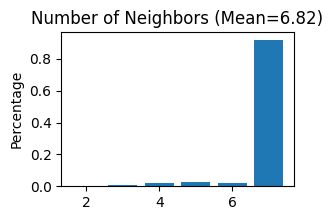

In [14]:
stHGC.cal_hybrid_graph(adata, rad_cutoff=150)
stHGC.stats_hybrid_graph(adata)


In [8]:
# adata = STAGATE.train_STAGATE(adata, alpha=0)
adata = stHGC.stHGC_train(adata)

Size of Input:  (4015, 3000)


100%|██████████| 1000/1000 [03:02<00:00,  5.49it/s]


In [9]:
sc.pp.neighbors(adata, use_rep='stHGC')
sc.tl.umap(adata)

In [10]:
adata = stHGC.mclust_R(adata, used_obsm='stHGC', num_cluster=5)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [13]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
nmi_score = normalized_mutual_info_score(obs_df['Ground Truth'], obs_df['mclust'])

print('Adjusted Rand Index = %.2f' % ARI)
print('Normalized Mutual Information Score = %.2f' % nmi_score)

Adjusted Rand Index = 0.78
Normalized Mutual Information Score = 0.76


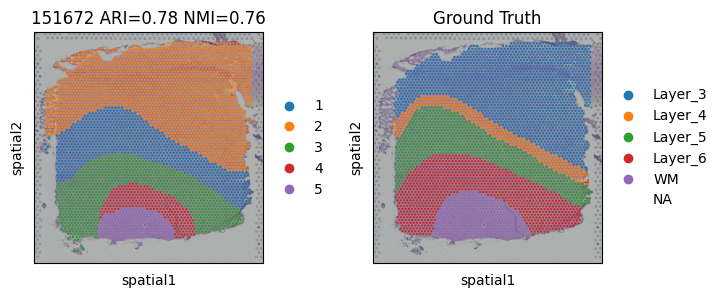

In [12]:
plt.rcParams["figure.figsize"] = (3, 3)
spatial_title = f"{section_id} ARI=%.2f NMI=%.2f" % (ARI, nmi_score)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=[spatial_title, "Ground Truth"])
plt.show()